# EDA

Open up all the files, explore their insides and take note of any insights for moving forward. 


## Insights

* Some customers visit many locations, some visit only 1
* So, for each customer, we need to make a prediction for every vendor for every location that customer visited.
*  ~250 customers in test dataset with missing meta data information. 

In [31]:
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd

from pathlib import Path

import hvplot.pandas

pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pth = Path('../data/raw/')
files = list(map(str, pth.glob('*.csv')))
files

['../data/raw/orders.csv',
 '../data/raw/SampleSubmission.csv',
 '../data/raw/test_locations.csv',
 '../data/raw/train_locations.csv',
 '../data/raw/vendors.csv',
 '../data/raw/test_customers.csv',
 '../data/raw/train_customers.csv']

## Load All Datasets

In [3]:
orders = pd.read_csv('../data/raw/orders.csv')

tr_locations = pd.read_csv('../data/raw/train_locations.csv')
te_locations = pd.read_csv('../data/raw/test_locations.csv')

vendors = pd.read_csv('../data/raw/vendors.csv')


tr_customers = pd.read_csv('../data/raw/train_customers.csv')
te_customers = pd.read_csv('../data/raw/test_customers.csv')

sample_sub = pd.read_csv('../data/raw/SampleSubmission.csv')

/Users/renierbotha/anaconda3/envs/zindi-akeed/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15,16,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Explore Datasets

### Sample Sub

In [4]:
sample_sub.head()

,CID X LOC_NUM X VENDOR,target
0,Z59FTQD X 0 X 243,0
1,0JP29SK X 0 X 243,0
2,0JP29SK X 1 X 243,0
3,0JP29SK X 2 X 243,0
4,0JP29SK X 3 X 243,0


Expand the index col

In [5]:
sample_sub[['customer_id','location_number','vendor_id']] = sample_sub['CID X LOC_NUM X VENDOR'].str.split(' X ', expand=True)

In [6]:
sample_sub.shape

(1672000, 5)

In [7]:
print('{} Customers in Sample Submission'.format(sample_sub.customer_id.nunique()))

10000 Customers in Sample Submission


In [8]:
sample_sub.sort_values(by='customer_id').head()

,CID X LOC_NUM X VENDOR,target,customer_id,location_number,vendor_id
640979,000IPH5 X 0 X 104,0,000IPH5,0,104
523939,000IPH5 X 0 X 110,0,000IPH5,0,110
1594019,000IPH5 X 0 X 849,0,000IPH5,0,849
1393379,000IPH5 X 0 X 577,0,000IPH5,0,577
941939,000IPH5 X 0 X 28,0,000IPH5,0,28


In [9]:
# Number of predictions per customer
sample_sub.customer_id.value_counts()

T1L5K29    1200
PEHRJ52    1100
529ZR7J    1000
NQJU5X3    1000
BKLWPZ8     900
           ... 
H0HCHGV     100
RNUSP71     100
6084EOL     100
AM8QD5Y     100
ZY9HY8Y     100
Name: customer_id, Length: 10000, dtype: int64

In [10]:
inspect = sample_sub.query('customer_id == "T1L5K29"')
print('This customer visited {} locations'.format(inspect.location_number.nunique()))
inspect.sort_values(by='location_number')

This customer visited 12 locations


,CID X LOC_NUM X VENDOR,target,customer_id,location_number,vendor_id
4362,T1L5K29 X 0 X 243,0,T1L5K29,0,243
957402,T1L5K29 X 0 X 294,0,T1L5K29,0,294
322042,T1L5K29 X 0 X 4,0,T1L5K29,0,4
1341962,T1L5K29 X 0 X 216,0,T1L5K29,0,216
940682,T1L5K29 X 0 X 28,0,T1L5K29,0,28
...,...,...,...,...,...
773491,T1L5K29 X 9 X 288,0,T1L5K29,9,288
37811,T1L5K29 X 9 X 250,0,T1L5K29,9,250
1425571,T1L5K29 X 9 X 582,0,T1L5K29,9,582
689891,T1L5K29 X 9 X 180,0,T1L5K29,9,180


**Insight**: So, for each customer, we need to make a prediction for every vendor _for every location that customer visited_. 

Vendors are obviously linked to some locations, so recommending certain vendors for certain locations would not make sense. We would either need to encode this link in the modelling step somehow, or post-process recommendations based on this prior knowledge. 

### Orders

In [12]:
orders.shape

(135303, 26)

In [11]:
orders.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,preparationtime,delivery_time,order_accepted_time,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,2019-08-01 04:03:00,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83


In [13]:
orders.akeed_order_id.nunique()

135221

In [14]:
print('Orders for {} different customers'.format(orders.customer_id.nunique()))

Orders for 27445 different customers


In [15]:
customers_orders = set(orders.customer_id)
print('{} Customers in training set with meta data & orders'.format(len(customers_orders.intersection(set(tr_customers.akeed_customer_id.unique())))))
print('{} Customers in testing set with meta data & orders'.format(len(customers_orders.intersection(set(te_customers.akeed_customer_id.unique())))))

26779 Customers in training set with meta data & orders
0 Customers in testing set with meta data & orders


In [16]:
print('{} customers have order details, but no meta data.'.format(len(customers_orders - set(tr_customers.akeed_customer_id.unique()))))

666 customers have order details, but no meta data.


**Insights** 
* We have no order details of test data customers 
* There are some customers in training set that have meta data, but no orders
* Looks like there we have order details for some customers but no meta data

In [17]:
orders.deliverydistance.hvplot.hist()

:Histogram   [deliverydistance]   (deliverydistance_count)

In [20]:
orders.grand_total.hvplot.hist(bins=50)

:Histogram   [grand_total]   (grand_total_count)

In [60]:
orders.grand_total.mean()

676.4785614509656

### Locations

In [32]:
tr_locations['train'] = True
te_locations['train'] = False

locations = pd.concat([tr_locations, te_locations])

In [108]:
locations.head()

,customer_id,location_number,location_type,latitude,longitude,geometry,train,CID x LOC_NUM
0,02SFNJH,0,NaN,1.682392,-78.789737,POINT (-78.78973718181859 1.682391538461576),True,02SFNJH X 0
1,02SFNJH,1,NaN,1.679137,0.766823,POINT (0.7668233053886399 1.679136545096203),True,02SFNJH X 1
2,02SFNJH,2,NaN,-0.498648,0.661241,POINT (0.6612414365454651 -0.4986483973653315),True,02SFNJH X 2
3,RU43CXC,0,Home,0.100853,0.438165,POINT (0.4381654655391504 0.1008532520270913),True,RU43CXC X 0
4,BDFBPRD,0,NaN,2.523125,0.733464,POINT (0.7334637242284848 2.523125243914389),True,BDFBPRD X 0


In [105]:
print('Locations for {} customers in train'.format(tr_locations.customer_id.nunique()))
print('Locations for {} customers in test'.format(te_locations.customer_id.nunique()))

Locations for 35400 customers in train
Locations for 10000 customers in test


**Insight**: Location data covers the most customers. 

In [30]:
tr_locations.hvplot.kde('latitude')

:Distribution   [latitude]   (Density)

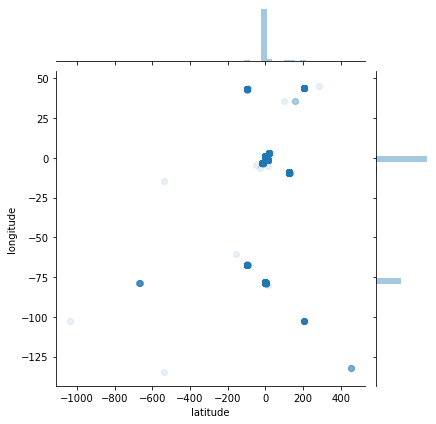

In [79]:
sns.jointplot(data=locations, x='latitude', y='longitude', alpha=.1)

There are two focal points of locations - around 0 lat & long and around (0, -75) lat,long. The size of that jump doesn't sound plausible though - a jump of 75 longitude is huge!!

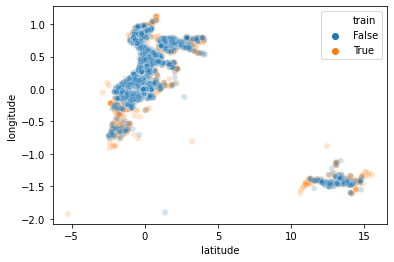

In [90]:
sns.scatterplot(data=locations.query('-2 < longitude < 2'), x='latitude', y='longitude', alpha=0.2, hue='train')

This looks like legit location data - if you look at Google maps it looks like the Northern coastlne of Oman, with Muscat at the horn. 

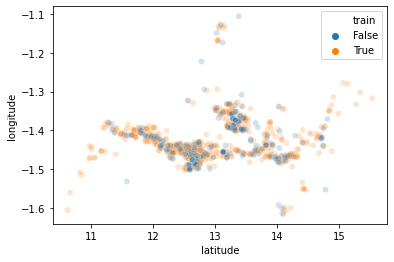

In [93]:
sns.scatterplot(data=locations.query('-2 < longitude < -1 and (latitude > 5)'), x='latitude', y='longitude', alpha=0.2, hue='train')

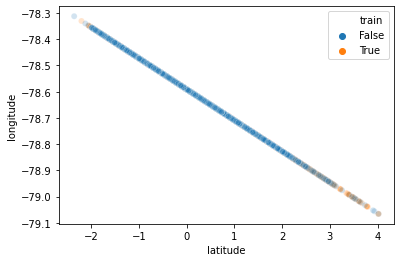

In [89]:
sns.scatterplot(data=locations.query('-10 < latitude < 10 and longitude < -10'), x='latitude', y='longitude', alpha=0.2, hue='train')

These coordinates are fucked

It looks like they added a bunch of noise to this dataset - the only locations that would make sense are those around -1, 1 longitude, which is where 99% of the vendors lie. 

In [85]:
print('{:.2f} % of locations are within longitude (-2, 2)'.format(100 *locations.query('-2 < longitude < 2').shape[0] / locations.shape[0]))

64.40 % of locations are within longitude (-1, 1)


In [104]:
locations.query('longitude > 2 or longitude < -1').customer_id.nunique()

22384

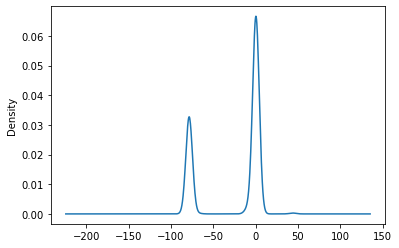

In [87]:
locations.longitude.plot.kde()

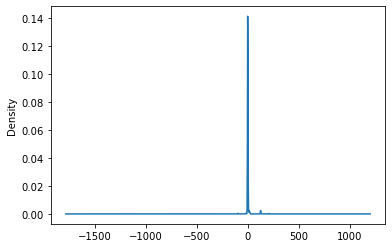

In [88]:
locations.latitude.plot.kde()

### Vendors

In [42]:
vendors.shape

(100, 59)

In [43]:
vendors.head()

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,-,15,0.0,Yes,0.0,1.0,1,11,EN,4.4,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,"{""primary_tags"":""4""}",1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,-,14,0.0,Yes,0.0,1.0,1,11,EN,4.7,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,"{""primary_tags"":""7""}",1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,-,19,0.0,Yes,0.0,1.0,1,1,EN,4.5,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,"{""primary_tags"":""71""}",1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,-,16,0.0,Yes,0.0,1.0,1,11,EN,4.5,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,"{""primary_tags"":""46""}",1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,-,10,0.0,Yes,0.0,1.0,1,11,EN,4.4,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00,"{""primary_tags"":""32""}",1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


In [45]:
# unique values per column
vendors.nunique().sort_values()

display_orders            1
city_id                   1
country_id                1
one_click_vendor          1
is_akeed_delivering       1
commission                1
language                  1
open_close_flags          1
device_type               2
rank                      2
is_open                   2
delivery_charge           2
vendor_category_id        2
vendor_category_en        2
status                    2
verified                  2
discount_percentage       5
tuesday_to_time2          6
thursday_to_time2         7
monday_to_time2           7
sunday_to_time2           7
saturday_to_time2         7
friday_to_time2           7
wednesday_to_time2        8
serving_distance         10
OpeningTime2             11
vendor_rating            12
prepration_time          14
wednesday_from_time2     15
tuesday_from_time2       15
thursday_from_time2      16
friday_from_time2        16
sunday_from_time2        16
monday_from_time2        16
saturday_from_time2      17
sunday_from_time1   

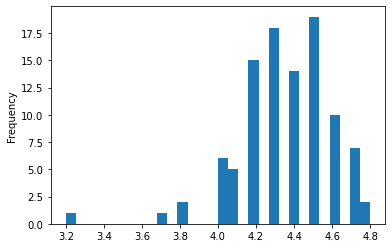

In [46]:
vendors.vendor_rating.plot.hist(bins=30)

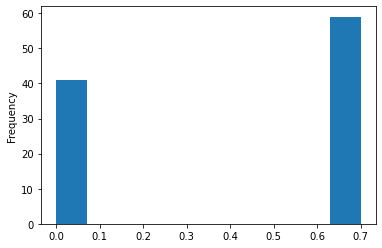

In [47]:
vendors.delivery_charge.plot.hist()

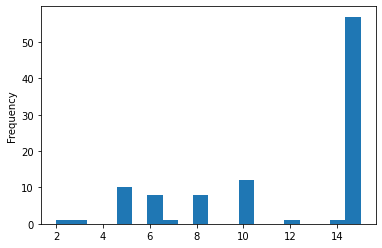

In [48]:
vendors.serving_distance.plot.hist(bins=20)

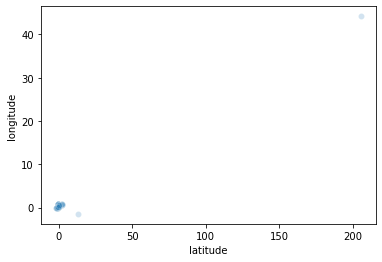

In [49]:
sns.scatterplot(data=vendors, x='latitude', y='longitude', alpha=.2)

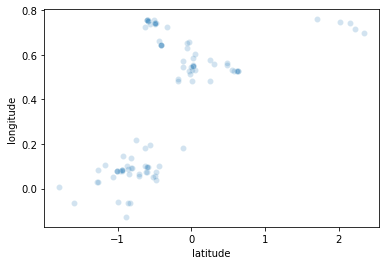

In [96]:
sns.scatterplot(data=vendors.query('latitude < 4'), x='latitude', y='longitude', alpha=.2)

**Insight**: Two outliers in vendor locations

Seems like we have vendors only for that one major cluster in the locations data... not sure what to do with the other locations though, because we still need to make predictions for those. I guess we could just make all zeros predictions for those locations, because they are too far from any vendors. 

---

### Customers

**Process Steps**:
* Rename `akeed_cusomter_id` to `customer_id`

In [97]:
tr_customers.head()

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01


In [98]:
te_customers.head()

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,ICE2DJP,Male,NaN,1,1,EN,2018-02-07 16:45:36,2018-02-07 16:45:36
1,FWNUI71,Male,NaN,1,1,EN,2018-03-22 20:11:47,2018-03-22 20:11:47
2,LRX7BCH,Male,NaN,1,1,EN,2018-04-17 20:01:15,2018-04-17 20:01:15
3,D96DHMD,Male,NaN,1,1,EN,2018-04-29 22:35:52,2018-04-29 22:35:52
4,88Q8Y5V,Male,1997.0,1,1,EN,2018-05-05 12:38:09,2018-05-05 12:38:09


In [99]:
te_customers.shape[0] == te_customers.akeed_customer_id.nunique(), 'has duplicates'

(False, 'has duplicates')

In [100]:
tr_customers.shape[0] == tr_customers.akeed_customer_id.nunique(), 'has duplicates'

(False, 'has duplicates')

In [101]:
print('{} customers in train'.format(tr_customers.akeed_customer_id.nunique()))
print('{} customers in test'.format(te_customers.akeed_customer_id.nunique()))

34523 customers in train
9753 customers in test


**Insights** 
* ~250 customers in test dataset with no meta data. 
* ~500 customers in train dataset with no meta data
* There are duplicate accounts in train and test data

In [ ]:
tr_customers.language.unique()

## Join Things together

In [115]:
locations['CID x LOC_NUM'] = locations['customer_id'] + ' X ' + locations['location_number'].astype(str)

In [110]:
orders['CID x LOC_NUM'] = orders['customer_id'] + ' X ' + orders['LOCATION_NUMBER'].astype(str)

In [111]:
orders.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,preparationtime,delivery_time,order_accepted_time,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR,CID x LOC_NUM
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105,92PEE24 X 0
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294,QS68UD8 X 0
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83,MB7VY5F X 0
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,2019-08-01 04:03:00,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90,KDJ951Y X 0
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83,BAL0RVT X 0


In [117]:
locations[['location_type','latitude','longitude','CID x LOC_NUM']]

,location_type,latitude,longitude,CID x LOC_NUM
0,NaN,1.682392,-78.789737,02SFNJH X 0
1,NaN,1.679137,0.766823,02SFNJH X 1
2,NaN,-0.498648,0.661241,02SFNJH X 2
3,Home,0.100853,0.438165,RU43CXC X 0
4,NaN,2.523125,0.733464,BDFBPRD X 0
...,...,...,...,...
16715,NaN,-0.197722,0.609199,L9G4OFV X 4
16716,NaN,-0.343042,0.626064,L9G4OFV X 5
16717,Home,-0.974907,-0.177863,FDZFYBA X 0
16718,Other,1.058539,0.001628,UTKHR1C X 0
